## Predicting Bike Rental Station Traffic

#### TODO:
- group stations in some way
- get an lstm working
- try many predict one first, then many predict many (maybe 12-24 hours)
- try out a gru/different architectures, cv
- see if more than one year helps
- include weather
- scale up, get one model for one station for many stations (all if possible)
- flask basic
- flask interactive
- repo writeup (requirements/put authorship in py/slice of data)

#### future:
- group stations (takes into account nearby traffic) like RNN that has more than one station's output
- live feed: https://gbfs.divvybikes.com/gbfs/gbfs.json

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from geopy.distance import geodesic

In [2]:
def basic_dist(row):
    # Gives a basic euclidean trip distance in m
    
    if row['round_trip'] == 1:
        return 0
    
    a = (row['start_lat'], row['start_lng'])
    
    b = (row['end_lat'], row['end_lng'])
    
    return geodesic(a, b).km * 1000

In [78]:
def station_data(stationid=None, eda=False):
    '''Loads, preps, and filters data for machine learning'''
    
    # Gather one years worth of data
    filelist = []
    frames = []
    
    for month in [4,5,6,7,8,9,10,11,12]:
        filelist.append('data/2020{:02d}-divvy-tripdata.csv'.format(month))
    for month in [1,2,3]:
        filelist.append('data/2021{:02d}-divvy-tripdata.csv'.format(month))
    
    usecols = ['started_at', 'ended_at', 'start_station_id', 'end_station_id', 'member_casual', 'rideable_type',
               'start_lat', 'start_lng', 'end_lat', 'end_lng']
    
    for month in filelist:
        lil_df = pd.read_csv(month, usecols=usecols)
        
        if stationid is not None:
            # filter for specific station
            mask1 = (lil_df['end_station_id'] == stationid)
            mask2 = (lil_df['start_station_id'] == stationid)
            mask = mask1 | mask2

            lil_df = lil_df[mask]
        
        frames.append(lil_df)

    df = pd.concat(frames, ignore_index=True)
    
    # Only relevant missing data is lat/long, warns us if any stations are losing more than 1% from dropping
    allrows = df.shape[0]
    
    df = df[df['start_lat'].notna()]
    df = df[df['end_lat'].notna()]
    if allrows/df.shape[0] > 1.01:
        print('NULL WARNING: more than 1% of rows null')

    # might not be necessary, but sort of a df label
    df = df.reset_index(drop=True)
    df.index = df.index.rename(stationid)

    # prepping for machine learning
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['started_at'] = pd.to_datetime(df['started_at'])

    df['date'] = pd.to_datetime(df['ended_at'].dt.date)
    df['hour'] = df['ended_at'].dt.hour
    
    # keep all hours for eda, otherwise only use 9am to 8pm (12 hours)
    if eda == False:
        df = df[df['hour'] <= 21]
        df = df[df['hour'] >= 9]

    # daylight savings makes a few negative trip times, a quick approximate fix is okay
    df['trip_time'] = abs((df['ended_at'] - df['started_at']).dt.total_seconds())

    df['round_trip'] = df.apply(lambda x: 1 if x['start_station_id'] == x['end_station_id'] else 0, axis=1)

    df['electric'] = df['rideable_type'].apply(lambda x: 1 if x == 'electric_bike' else 0)

    df['member'] = df['member_casual'].apply(lambda x: 1 if x == 'member' else 0)
    
    # 1 if bike is coming to station, 0 if leaving. Hopefully useful for ratios
    df['entering'] = df['end_station_id'].apply(lambda x: 1 if x == stationid else 0)

    # takes time but is more accurate and in meters. Can convert to euclidean coord dist to save time
    '''UNCOMMENT THIS LATER'''
    df['trip_dist'] = df.apply(basic_dist, axis=1)
    
    dropcols = ['rideable_type', 'member_casual', 'started_at', 'ended_at',
                'start_lat', 'start_lng', 'end_lat', 'end_lng']
    
    if stationid is not None:
        dropcols.append('start_station_id')
        dropcols.append('end_station_id')
    
    df = df.drop(columns=dropcols)
    
    # Can only use aggregate statistics on the hour

    return df

In [79]:
df35 = station_data(35)

df35

,date,hour,trip_time,round_trip,electric,member,entering,trip_dist
35,,,,,,,,
0,2020-04-30,18,324.0,0,0,1,1,953.433498
1,2020-04-02,14,313.0,0,0,1,0,771.019785
2,2020-04-05,18,4065.0,0,0,0,1,3204.948053
3,2020-04-25,18,1760.0,0,0,1,1,2523.817732
4,2020-04-07,19,1994.0,0,0,1,1,2825.757522
...,...,...,...,...,...,...,...,...
60587,2020-11-28,14,2177.0,0,0,0,1,5838.540699
60589,2020-11-07,13,2177.0,0,0,0,1,4913.115625
60590,2020-11-07,16,1667.0,0,0,0,1,4256.160320


In [80]:
df35.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55802 entries, 0 to 60592
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        55802 non-null  datetime64[ns]
 1   hour        55802 non-null  int64         
 2   trip_time   55802 non-null  float64       
 3   round_trip  55802 non-null  int64         
 4   electric    55802 non-null  int64         
 5   member      55802 non-null  int64         
 6   entering    55802 non-null  int64         
 7   trip_dist   55802 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 3.8 MB


In [89]:
df35a = df35.groupby(['date', 'hour']).agg('mean')

df35a['size'] = df35.groupby(['date', 'hour']).size()

df35a

trip_time  round_trip  electric  member  entering  \
date       hour                                                      
2020-04-01 11       2566.0         0.0       0.0     1.0       1.0   
           16        233.0         0.0       0.0     1.0       0.0   
2020-04-02 9         366.0         0.0       0.0     1.0       0.0   
           13       3312.0         0.0       0.0     1.0       0.0   
           14        313.0         0.0       0.0     1.0       0.0   
...                    ...         ...       ...     ...       ...   
2020-11-30 12       1263.0         0.0       1.0     1.0       1.0   
           14       1628.5         0.0       0.0     0.0       1.0   
           16        179.0         0.0       1.0     1.0       1.0   
           18       1725.0         0.0       0.0     1.0       0.0   
           21        752.0         0.0       0.0     1.0       1.0   

                   trip_dist  size  
date       hour                     
2020-04-01 11    5627.490317     1  
           16     771.019785     1  
2020-04-02 9      771.019785     1  
           13    1717.595674     1  
           14     771.019785     1  
...                      ...   ...  
2020-11-30 12    2844.798866     1  
           14    1043.273717     2  
           16     776.745231     1  
           18    3959.468087     1  
           21    2069.734803     1  

[2551 rows x 7 columns]

In [29]:
df35b = df35.groupby(['hour']).agg(['sum', 'count'])

df35b

trip_time       round_trip       electric       member       entering  \
             sum count        sum count      sum count    sum count      sum   
hour                                                                           
0      1574567.0   452        117   452       16   452     32   452      252   
1       888441.0   193         62   193       11   193     19   193      115   
2       556132.0   120         37   120        7   120     12   120       64   
3       602481.0   101         38   101        3   101      2   101       54   
4       158673.0    36         11    36        1    36      4    36       22   
5       432839.0    72          6    72        1    72     33    72       58   
6      1286700.0   339         22   339       19   339    228   339      237   
7      2103544.0   684         76   684       59   684    486   684      321   
8      2062494.0   827         62   827       67   827    623   827      347   
9      2665555.0  1018         89  1018       98  1018    532  1018      600   
10     4220064.0  1652        147  1652      169  1652    632  1652     1042   
11     6688837.0  2839        228  2839      203  2839    832  2839     1887   
12     9423535.0  3827        275  3827      294  3827    901  3827     2375   
13    11458695.0  4740        382  4740      350  4740   1042  4740     3011   
14    13922259.0  5500        494  5500      325  5500   1114  5500     3248   
15    17691797.0  5927        612  5927      372  5927   1168  5927     3525   
16    15937051.0  6365        601  6365      392  6365   1290  6365     3617   
17    15623021.0  6426        624  6426      373  6426   1629  6426     3653   
18    14209080.0  6126        705  6126      379  6126   1674  6126     3511   
19    12189700.0  5023        543  5023      231  5023   1422  5023     2714   
20     9957053.0  3886        529  3886      134  3886    930  3886     1962   
21     8099775.0  2473        377  2473       87  2473    429  2473     1079   
22     4008459.0  1295        203  1295       50  1295    175  1295      555   
23     2270394.0   672        143   672       22   672     89   672      317   

            
     count  
hour        
0      452  
1      193  
2      120  
3      101  
4       36  
5       72  
6      339  
7      684  
8      827  
9     1018  
10    1652  
11    2839  
12    3827  
13    4740  
14    5500  
15    5927  
16    6365  
17    6426  
18    6126  
19    5023  
20    3886  
21    2473  
22    1295  
23     672

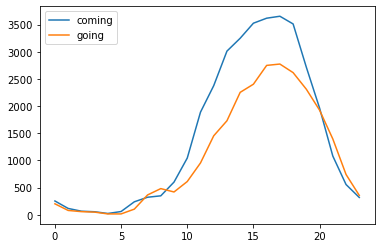

In [35]:
# make this into a function later

# ratio of coming / going per hour, uses agg mean
fig, ax = plt.subplots()

ax.plot(df35b.index, df35b['entering', 'sum'], label='coming')
ax.plot(df35b.index, df35b['entering', 'count'] - df35b['entering', 'sum'], label='going')
ax.legend();

## pick busiest stations
most stations will probably not have an exchange for every hour



In [92]:
dfall = station_data(None)

dfall

,start_station_id,end_station_id,date,hour,trip_time,round_trip,electric,member,entering,trip_dist
0,86,152.0,2020-04-26,18,1609.0,0,0,1,0,3981.345842
1,503,499.0,2020-04-17,17,489.0,0,0,1,0,979.629317
2,142,255.0,2020-04-01,18,863.0,0,0,1,0,2984.661192
3,216,657.0,2020-04-07,13,732.0,0,0,1,0,2141.374633
4,125,323.0,2020-04-18,11,3175.0,0,0,0,0,9119.684872
...,...,...,...,...,...,...,...,...,...,...
3485005,13042,TA1306000013,2021-03-20,17,8631.0,0,0,0,0,1202.115491
3485006,KA1503000043,TA1306000013,2021-03-02,11,507.0,0,0,1,0,1661.041299
3485007,13042,KA1504000146,2021-03-09,11,2495.0,0,0,1,0,9310.940595
3485008,KA1503000043,TA1306000013,2021-03-01,18,400.0,0,0,1,0,1661.041299


In [10]:
dfalla = dfall.groupby(['date', 'hour']).agg('mean')

dfalla

trip_time  round_trip  electric    member  entering
date       hour                                                         
2020-04-01 0        559.636364    0.090909       0.0  0.818182       0.0
           1        428.500000    0.000000       0.0  1.000000       0.0
           2       1337.500000    0.500000       0.0  0.500000       0.0
           3        729.333333    0.333333       0.0  0.666667       0.0
           4        870.250000    0.250000       0.0  0.750000       0.0
...                        ...         ...       ...       ...       ...
2021-04-02 19    268752.000000    0.000000       0.0  0.000000       0.0
2021-04-03 16    340714.000000    0.000000       0.0  0.000000       0.0
           18    346104.000000    0.000000       0.0  0.000000       0.0
2021-04-04 16    684094.500000    1.000000       0.0  0.000000       0.0
2021-04-06 11    666513.000000    0.000000       0.0  0.000000       0.0

[8661 rows x 5 columns]

In [93]:
dfall['end_station_id'].value_counts()

35.0       32224
177.0      26666
176.0      23783
76.0       23325
268.0      23310
           ...  
20248.0        1
593            1
20105          1
569            1
20125          1
Name: end_station_id, Length: 1342, dtype: int64

In [38]:
dfall = dfall.groupby(['date', 'hour']).agg('count')

In [41]:
dfall

start_station_id  end_station_id  trip_time  round_trip  \
date       hour                                                            
2020-04-01 0                   11              11         11          11   
           1                    2               2          2           2   
           2                    2               2          2           2   
           3                    3               3          3           3   
           4                    4               4          4           4   
...                           ...             ...        ...         ...   
2021-04-02 19                   1               1          1           1   
2021-04-03 16                   1               1          1           1   
           18                   1               1          1           1   
2021-04-04 16                   2               2          2           2   
2021-04-06 11                   1               1          1           1   

                 electric  member  entering  
date       hour                              
2020-04-01 0           11      11        11  
           1            2       2         2  
           2            2       2         2  
           3            3       3         3  
           4            4       4         4  
...                   ...     ...       ...  
2021-04-02 19           1       1         1  
2021-04-03 16           1       1         1  
           18           1       1         1  
2021-04-04 16           2       2         2  
2021-04-06 11           1       1         1  

[8661 rows x 7 columns]

In [82]:
dti = pd.Series(pd.date_range("2020-04-01", freq="D", periods=365))

idx = pd.MultiIndex.from_product([dti, [9,10,11,12,13,14,15,16,17,18,19,20]], names=['date', 'hour'])

In [83]:
df_blank = pd.DataFrame(data = np.zeros(shape=(365*12, 6)), index=idx,
                        columns=['trip_time', 'round_trip', 'electric', 'member', 'entering', 'trip_dist'])

df_blank

trip_time  round_trip  electric  member  entering  trip_dist
date       hour                                                              
2020-04-01 9           0.0         0.0       0.0     0.0       0.0        0.0
           10          0.0         0.0       0.0     0.0       0.0        0.0
           11          0.0         0.0       0.0     0.0       0.0        0.0
           12          0.0         0.0       0.0     0.0       0.0        0.0
           13          0.0         0.0       0.0     0.0       0.0        0.0
...                    ...         ...       ...     ...       ...        ...
2021-03-31 16          0.0         0.0       0.0     0.0       0.0        0.0
           17          0.0         0.0       0.0     0.0       0.0        0.0
           18          0.0         0.0       0.0     0.0       0.0        0.0
           19          0.0         0.0       0.0     0.0       0.0        0.0
           20          0.0         0.0       0.0     0.0       0.0        0.0

[4380 rows x 6 columns]

In [84]:
df35a

trip_time  round_trip  electric  member  entering  \
date       hour                                                      
2020-04-01 11       2566.0         0.0       0.0     1.0       1.0   
           16        233.0         0.0       0.0     1.0       0.0   
2020-04-02 9         366.0         0.0       0.0     1.0       0.0   
           13       3312.0         0.0       0.0     1.0       0.0   
           14        313.0         0.0       0.0     1.0       0.0   
...                    ...         ...       ...     ...       ...   
2020-11-30 12       1263.0         0.0       1.0     1.0       1.0   
           14       1628.5         0.0       0.0     0.0       1.0   
           16        179.0         0.0       1.0     1.0       1.0   
           18       1725.0         0.0       0.0     1.0       0.0   
           21        752.0         0.0       0.0     1.0       1.0   

                   trip_dist  
date       hour               
2020-04-01 11    5627.490317  
           16     771.019785  
2020-04-02 9      771.019785  
           13    1717.595674  
           14     771.019785  
...                      ...  
2020-11-30 12    2844.798866  
           14    1043.273717  
           16     776.745231  
           18    3959.468087  
           21    2069.734803  

[2551 rows x 6 columns]

In [86]:
df35c = pd.concat([df_blank, df35a])

In [88]:
df35c.groupby(['date', 'hour']).agg('sum').iloc[250:300]

trip_time  round_trip  electric  member  entering  \
date       hour                                                        
2020-04-21 15     598.000000         0.0       0.0     0.0       1.0   
           16       0.000000         0.0       0.0     0.0       0.0   
           17    1571.000000         0.0       0.0     0.0       1.0   
           18       0.000000         0.0       0.0     0.0       0.0   
           19       0.000000         0.0       0.0     0.0       0.0   
           20       0.000000         0.0       0.0     0.0       0.0   
2020-04-22 9        0.000000         0.0       0.0     0.0       0.0   
           10       0.000000         0.0       0.0     0.0       0.0   
           11       0.000000         0.0       0.0     0.0       0.0   
           12     395.000000         0.0       0.0     1.0       0.0   
           13       0.000000         0.0       0.0     0.0       0.0   
           14     230.000000         0.0       0.0     1.0       0.0   
           15       0.000000         0.0       0.0     0.0       0.0   
           16       0.000000         0.0       0.0     0.0       0.0   
           17       0.000000         0.0       0.0     0.0       0.0   
           18     332.000000         0.0       0.0     1.0       1.0   
           19       0.000000         0.0       0.0     0.0       0.0   
           20       0.000000         0.0       0.0     0.0       0.0   
2020-04-23 9        0.000000         0.0       0.0     0.0       0.0   
           10       0.000000         0.0       0.0     0.0       0.0   
           11       0.000000         0.0       0.0     0.0       0.0   
           12     422.000000         0.0       0.0     1.0       0.0   
           13       0.000000         0.0       0.0     0.0       0.0   
           14     400.000000         0.0       0.0     1.0       0.5   
           15       0.000000         0.0       0.0     0.0       0.0   
           16     240.000000         0.0       0.0     1.0       1.0   
           17       0.000000         0.0       0.0     0.0       0.0   
           18       0.000000         0.0       0.0     0.0       0.0   
           19    1041.500000         0.0       0.0     0.5       0.5   
           20       0.000000         0.0       0.0     0.0       0.0   
2020-04-24 9        0.000000         0.0       0.0     0.0       0.0   
           10     476.000000         0.0       0.0     1.0       0.0   
           11       0.000000         0.0       0.0     0.0       0.0   
           12       0.000000         0.0       0.0     0.0       0.0   
           13       0.000000         0.0       0.0     0.0       0.0   
           14     223.000000         0.0       0.0     1.0       0.0   
           15       0.000000         0.0       0.0     0.0       0.0   
           16       0.000000         0.0       0.0     0.0       0.0   
           17     375.000000         0.0       0.0     1.0       0.0   
           18     274.000000         0.0       0.0     1.0       1.0   
           19     371.000000         0.0       0.0     0.0       1.0   
           20       0.000000         0.0       0.0     0.0       0.0   
2020-04-25 9        0.000000         0.0       0.0     0.0       0.0   
           10       0.000000         0.0       0.0     0.0       0.0   
           11       0.000000         0.0       0.0     0.0       0.0   
           12       0.000000         0.0       0.0     0.0       0.0   
           13    4151.666667         0.0       0.0     0.0       0.0   
           14    1148.000000         0.0       0.0     0.0       1.0   
           15       0.000000         0.0       0.0     0.0       0.0   
           16       0.000000         0.0       0.0     0.0       0.0   

                   trip_dist  
date       hour               
2020-04-21 15    2007.938952  
           16       0.000000  
           17    2738.424943  
           18       0.000000  
           19       0.000000  
           20       0.000000  
2020-04-22 9        0.0000

In [ ]:
def serialize(inputdf):
    ''''''
    
    out = inputdf.groupby(['date', 'hour']).agg('mean')
    
    out['size'] = out.groupby(['date', 'hour']).size()

#### groups
loosely based off this map: https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations-All-Map/bk89-9dk7

In [110]:
# Downtown
group_a = set([92,146,47,217,285,31,119,191,286,21,53,125,32,173,96,6,181,
           39,77,33,7,196,86,81,638,110,24,627,107,109,277,212,198,
           264,45,2,89,84,75,98,211,337,164,37,161,25,672,195,43,636,
           36,142,197,350,175,169,26,35,111,66,215,192,635,56,18,74,
           122,100,233,76,624,199,631,5,73,174,80,38,186,383,106,194,
           40,621,52,48,99,346,51,91,284,68,88,49,134,90,44,54,71,112,
           283,623,287,133,50,637,654,1436495109493626600,
           1436495105198659300])

len(group_a)

109

In [111]:
# Lincoln park
group_b = set([127,163,327,131,188,349,288,177,223,162,157,319,67,87,143,
           154,226,220,302,153,505,141,34,58,115,310,228,300,332,219,
           258,144,329,250,94,166,340,307,156,324,296,334,13,504,313,
           309,225,673,190,152,117,113,343,664,1436495100903692000,
           1436495105198659300,1436495118083561200,1521690221159885800])

len(group_b)

58

In [112]:
# Wicker park
group_c = set([666,92,69,158,224,365,511,506,86,276,183,213,216,510,305,
           622,128,58,331,130,659,20,315,61,219,17,509,16,508,350,93,
           657,30,374,29,159,160,210,628,60,373,116,333,54,641,637,643,
           658,1436495119852630500,1521686986436309800,])

len(group_c)

50

In [113]:
# Hyde park
group_d = set([12,564,567,121,431,561,426,101,418,345,559,11,565,569,398,
           568,388,652,328,393,248,560,572,428,562,385,102,95,355,653,
           427,392,395,415,247,555,386,400,421,422,556,399,351,423,
           420,575,557,424,593,570,391,647,356,396,384,430,352,571,554,
           563,390,425,429,270,322,558,417,204,419,649,650,674,646,648,
           678,679])

len(group_d)

76

In [114]:
# Uptown
group_e = set([245,481,478,234,240,312,292,475,311,463,238,465,471,316,
           231,472,326,486,243,297,253,246,314,298,249,306,323,295,
           318,239,325,242,251,244,256,476,477,639,254,480,293,464,
           482,344])

len(group_e)

44

In [115]:
# Chinatown
group_f = set([402,62,403,272,132,280,401,120,339,406,207,171,370,148,147,
           237,193,4,135,184,206,42,366,209,335,150,208,368,263,149])

len(group_f)

30